In [1]:
from gemelli import rpca
import biom 
import pandas as pd
import numpy as np
import qiime2 as q2

from sklearn.model_selection import train_test_split
from qiime2.plugins import emperor

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wol2_bt = biom.load_table('/projects/thdmi/feature-tables/wol2_filtered_table_zebra.biom')
ko_bt = biom.load_table('/projects/thdmi/feature-tables/kegg_filtered_table_zebra.biom') 
pathways_bt = biom.load_table('/projects/thdmi/feature-tables/pathways_filtered_table_zebra.biom')

metadata = q2.Metadata.load('/projects/thdmi/metadata/consolidated_metadata_subset.tsv').to_dataframe()
wol2_bt.filter(metadata.index.intersection(wol2_bt.ids()))
ko_bt.filter(metadata.index.intersection(ko_bt.ids()))
pathways_bt.filter(metadata.index.intersection(pathways_bt.ids()))

352 x 1177 <class 'biom.table.Table'> with 336820 nonzero entries (81% dense)

In [3]:
metadata_subset = metadata.loc[metadata.index.intersection(wol2_bt.ids())]

In [4]:
train_, test_ = train_test_split(metadata_subset, test_size = 0.5,
                                 stratify=metadata_subset[['thdmi_cohort', 'age_cat']],
                                 random_state=6)
metadata_subset['train_test'] = 'test'
metadata_subset.loc[train_.index, 'train_test'] = 'train'

/home/adilmore/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/adilmore/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/adilmore/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/adilmore/gemelli/gemelli/rpca.py:740: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sample_metadata = sample_metadata.loc[shared_all_samples, :]
/home/adilmore/gemelli/gemelli/rpca.py:900: RuntimeWarning: Removing 0 features(s) in table(s) but not the ordination.
  warnings.warn('Removing %i features(s) in table(s)'


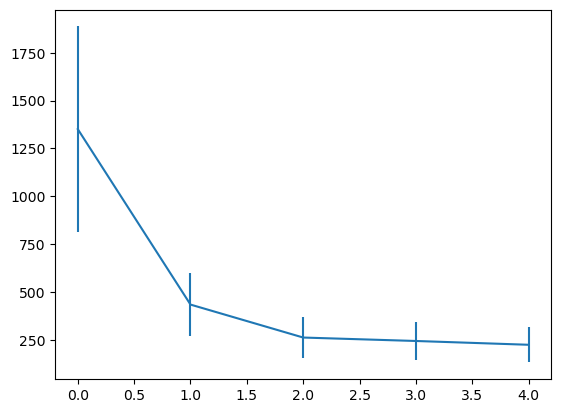

In [5]:
ordination, dm, cv = rpca.joint_rpca(tables=[wol2_bt, ko_bt, pathways_bt], n_test_samples = 200, sample_metadata=metadata_subset, train_test_column='train_test', n_components=3)
corr_table = rpca.feature_correlation_table(ordination)
plt.errorbar(x=cv.index, y=cv['mean_CV'], yerr=cv['std_CV']/2)
plt.show()

In [9]:
q2.Artifact.import_data('DistanceMatrix', dm).save('/projects/thdmi/basics/results/joint_rpca_dm.qza')

'/projects/thdmi/basics/results/joint_rpca_dm.qza'

In [14]:
from qiime2.plugins import diversity 

In [18]:
jrpca_dm = q2.Artifact.import_data('DistanceMatrix', dm)
jrpca_pcoa = diversity.methods.pcoa(jrpca_dm, 3).pcoa
jrpca_emp = emperor.visualizers.plot(jrpca_pcoa, q2.Metadata(metadata_subset))

In [20]:
jrpca_emp.visualization.save('/projects/thdmi/basics/results/joint_rpca_plot.qzv')

'/projects/thdmi/basics/results/joint_rpca_plot.qzv'

In [49]:
wol2_bt = biom.load_table('/projects/thdmi/feature-tables/wol2_filtered_table_zebra.biom')
ko_bt = biom.load_table('/projects/thdmi/feature-tables/kegg_filtered_table_zebra.biom') 
pathways_bt = biom.load_table('/projects/thdmi/feature-tables/pathways_filtered_table_zebra.biom')

foods_q2 = q2.Metadata.load('/projects/thdmi/metadata/consolidated_metadata_subset.tsv')
foods = foods_q2.to_dataframe()
#foods = foods.loc[foods['types_of_plants'].notna()]
foods.rename_axis(index='SampleID', inplace=True)

common_ids = foods.index.intersection(wol2_bt.ids())
wol2_bt.filter(common_ids)

collapsed_foods = foods.columns[foods.columns.str.startswith('Collapsed')]
all_foods = foods.columns[foods.columns.str.startswith('GramsPerDay')]
ultraprocessed = foods.columns[foods.columns.str.startswith('Processed')]

food_data = foods[collapsed_foods.union(all_foods).union(ultraprocessed)]
food_data.replace({np.nan: 0}, inplace=True)
food_data_q2 = q2.Artifact.import_data('FeatureTable[Frequency]', food_data)
food_data_bt = food_data_q2.view(biom.Table)
food_data_bt.filter(common_ids)

/tmp/ipykernel_21126/4084200567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  food_data.replace({np.nan: 0}, inplace=True)


627 x 1177 <class 'biom.table.Table'> with 219444 nonzero entries (29% dense)

In [50]:
train_, test_ = train_test_split(foods, test_size = 0.5,
                                 stratify=foods[['thdmi_cohort', 'age_cat']],
                                 random_state=6)
foods['train_test'] = 'test'
foods.loc[train_.index, 'train_test'] = 'train'

In [67]:
wol2_table_q2 = q2.Artifact.import_data('FeatureTable[Frequency]', wol2_bt)
food_table_q2 = q2.Artifact.import_data('FeatureTable[Frequency]', food_data_bt)

In [68]:
wol2_table_q2.save('wol2_table.qza')
food_table_q2.save('food_table.qza')

'food_table.qza'

In [70]:
foods['train_test'].replace({'train': 'Train', 'test': 'Test'}, inplace=True)
foods[['thdmi_cohort', 'age_cat', 'train_test', 'antibiotic_history', 'covid_level_of_wellbeing', 'types_of_plants', 'bmi_cat']].to_csv('mmvec_metadata.tsv', sep='\t')

/home/adilmore/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/adilmore/gemelli/gemelli/preprocessing.py:418: RuntimeWarning: divide by zero encountered in log
  mat = np.log(matrix_closure(mat))
/home/adilmore/gemelli/gemelli/rpca.py:740: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  sample_metadata = sample_metadata.loc[shared_all_samples, :]
/home/adilmore/gemelli/gemelli/rpca.py:900: RuntimeWarning: Removing 0 features(s) in table(s) but not the ordination.
  warnings.warn('Removing %i features(s) in table(s)'


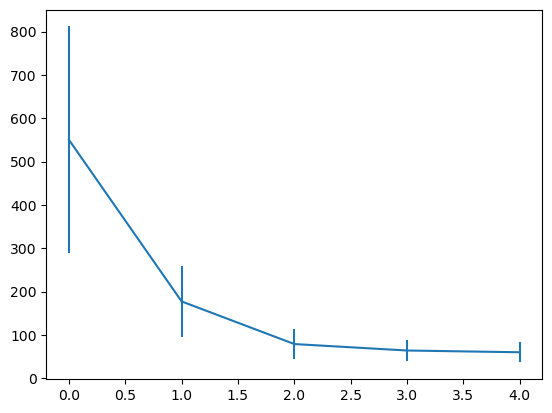

In [51]:
ordination, dm, cv = rpca.joint_rpca(tables=[wol2_bt, food_data_bt], n_test_samples = 200, sample_metadata=foods, train_test_column='train_test', n_components=3)
corr_table = rpca.feature_correlation_table(ordination)
plt.errorbar(x=cv.index, y=cv['mean_CV'], yerr=cv['std_CV']/2)
plt.show()

In [52]:
food_data_bt

615 x 1177 <class 'biom.table.Table'> with 219444 nonzero entries (30% dense)

In [53]:
biplot = q2.Artifact.import_data("PCoAResults % Properties('biplot')", ordination)

emp_biplot = emperor.visualizers.biplot(biplot, foods_q2, number_of_features = 10).visualization
emp_biplot.save('emperor_biplot.qzv')

'emperor_biplot.qzv'

In [ ]:
corr_table.loc[corr_table.index.intersection(ultraprocessed)][corr_table.index.intersection(wol2_bt.ids(axis='observation'))]

In [62]:
corr_table.loc[corr_table.index.intersection(ultraprocessed)][corr_table.index.intersection(wol2_bt.ids(axis='observation'))]

featureid,G000006605,G000006785,G000006845,G000006865,G000006925,G000007265,G000007325,G000007525,G000007745,G000007785,...,G902794445,G902798515,G902798535,G902798655,G902798845,G902799635,G902800075,G902801795,G902801825,G902801975
Processed_Calories_Nova_processed_culinary_ingredients,0.999549,0.999796,0.999636,-0.991809,-0.991203,0.999559,0.999693,-0.999956,0.999745,-0.949400,...,0.999749,0.998335,0.999840,0.999658,0.999605,0.997464,0.999948,0.996862,0.996540,0.998806
Processed_Calories_Nova_processed_foods,-0.628812,-0.658344,-0.664031,0.718708,0.732671,-0.635961,-0.651258,0.652493,-0.662388,0.855622,...,-0.655911,-0.656404,-0.651154,-0.657972,-0.641590,-0.686127,-0.657242,-0.666889,-0.675265,-0.670311
Processed_Calories_Nova_ratio_any_processed_unprocessed,0.999649,0.999606,0.999437,-0.987259,-0.987037,0.999939,0.999869,-0.999598,0.999446,-0.945420,...,0.999729,0.999458,0.999795,0.999698,0.999976,0.997899,0.999369,0.998393,0.997919,0.999167
Processed_Calories_Nova_ratio_ultra_processed_unprocessed,0.998660,0.999770,0.999835,-0.989393,-0.989820,0.999287,0.999805,-0.999491,0.999759,-0.954368,...,0.999821,0.999795,0.999687,0.999887,0.999551,0.999361,0.999421,0.999263,0.999114,0.999935
Processed_Calories_Nova_ultra_processed_foods,-0.999571,-0.998286,-0.997798,0.988823,0.987195,-0.999025,-0.998394,0.998875,-0.998057,0.936735,...,-0.998288,-0.996197,-0.998667,-0.998044,-0.998756,-0.993949,-0.998709,-0.993857,-0.993122,-0.996286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Processed_Grams_Subgroup_table_salt,0.999803,0.999793,0.999596,-0.990149,-0.989571,0.999852,0.999838,-0.999939,0.999686,-0.946938,...,0.999810,0.998721,0.999921,0.999724,0.999863,0.997471,0.999839,0.997299,0.996883,0.998890
Processed_Grams_Subgroup_table_sugar,0.995554,0.998346,0.998689,-0.995988,-0.996637,0.996189,0.997641,-0.997986,0.998647,-0.967969,...,0.998094,0.996827,0.997765,0.998189,0.996722,0.998576,0.998386,0.996359,0.996780,0.998464
Processed_Grams_Subgroup_tofu__soy_or_meat_substitute,0.998563,0.999750,0.999831,-0.989504,-0.989975,0.999213,0.999770,-0.999453,0.999749,-0.954936,...,0.999797,0.999786,0.999649,0.999868,0.999492,0.999428,0.999393,0.999290,0.999164,0.999955
Processed_Grams_Subgroup_ultra_processed_legume_products,-0.977651,-0.983596,-0.984440,0.997927,0.998781,-0.978154,-0.981378,0.983175,-0.984510,0.982643,...,-0.982713,-0.978651,-0.982049,-0.982830,-0.979172,-0.984667,-0.984531,-0.978103,-0.979625,-0.983354


# metadata

In [2]:
wol2_table = q2.Artifact.load('wol2_table.qza').view(pd.DataFrame)
food_table = q2.Artifact.load('food_table.qza').view(pd.DataFrame)

In [15]:
wol2_metadata = q2.Artifact.import_data(type='FeatureData[Taxonomy]', view='/projects/wol/qiyun/wol2/taxonomy/lineages.txt', view_type='HeaderlessTSVTaxonomyFormat') 
wol2_md = wol2_metadata.view(pd.DataFrame)
wol2_md[['domain', 'phylum', 'class', 'order', 'family', 'genus', 'species']] = wol2_md['Taxon'].str.split(';', expand=True)
wol2_md.drop(columns=['Taxon'], inplace=True) 
wol2_md.to_csv('wol2_taxonomy.tsv', sep='\t')

In [66]:
# fermented foods
# non-fermented collapsed 
# GramsPerDay 
# Processed grams 
# Processed calories

fermented = food_table.columns[food_table.columns.str.startswith('Collapsed_Fermented')]
fermented_names = {i:'_'.join(i.split('_')[1:]) for i in fermented} 
collapsed = food_table.columns[food_table.columns.str.startswith('Collapsed_Foods')]
collapsed_names = {i:'_'.join(i.split('_')[2:]) for i in collapsed}
individual_foods = food_table.columns[food_table.columns.str.startswith('GramsPerDay')]
individual_food_names = {i:'_'.join(i.split('_')[1:len(i.split('_'))-2]) for i in individual_foods}
processed = food_table.columns[food_table.columns.str.startswith('Processed_')]
processed_names = {i:i for i in processed}

fermented_names.update(collapsed_names)
fermented_names.update(individual_food_names)
fermented_names.update(processed_names)
food_md = pd.DataFrame.from_dict(fermented_names, orient='index', columns=['Name'])
names = []
for i in food_md.index: 
    if i in fermented: 
        names.append('Fermented') 
    elif i in collapsed: 
        names.append('Collapsed_Foods')
    elif i in individual_foods: 
        names.append('Individual_Foods')
    else: 
        names.append('Processed')
food_md['Category'] = names
food_md.rename_axis(index='Feature ID', inplace=True)
food_md.to_csv('food_metadata.tsv', sep='\t')